<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/hannahklingberg-lab6/Lab6/hannahklingberg_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Differential Equations**
**Hanna Klingberg**

# **Abstract**

This lab explores using time stepping functions to approximate solutions to differential equations, stated in the form of initial value problems (IVPs). Both scalar IVPs and systems of IVPs are approximated, and the accuracy and stability of the approximations are investigated. Using the theta method to approximate the solutions, where different values of theta (0, 0.5, 1) results in the method being either the implicit Euler method, the trapezoidal method or the explicit Euler method. It is clear from the results that the trapezoidal method gives the best approximation on the model problem. 

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [114]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [115]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
import scipy.optimize as optimize
import random

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common 
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *
    
#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Time stepping methods are used to solve ordinary differential equations of the form:


$\dot{u}(t) = f(u(t),t),$ 
$0 < t < T$

$u(0) = u_0 $ 

Which are called initial value problems (IVPs). The solution to these problems have to be approximated, which can be done with time-stepping methods, where successive approximations $U(t_n)$ are computed on a partition 
$0 = t_0 < t1 < ... < t_N = T $

# **Method**

# **Time stepping for scalar intital value problem $\frac{du}{dt} = f(u,t)$**

To solve the scalar IVP, the theta method (adapted from pseudo-code for algorithm 13.3, chapter 13.2 in course book) can be used to approximate the solution. By setting $θ$ to 1, the theta method gives the explicit Euler method. $θ=0.5$ gets us the trapezoidal method and $θ = 0$ gives us the implicit Euler method. The theta method uses newtons method to approximate, which is used with the built-in function from scipy. 

To test the accuracy of the method, the model problem is adapted such that $f(u(t),t) = αu(t)$ and $u(0) = 1$. The exact solution is then $u(t) = exp(αt)$. Using this, the exact solution can be plotted against the approximated solution. 

To test the stability of the method we again adapt the model problem given in equation 13.12 in course book, with initial value $u(0)=1$, $\dot{u}(t) = λu(t)$, $λ = -10$ and $k = 0.25$ 

Thus, since $|1+kλ| > 1$, the explicit Euler method ($θ = 1$) is expected to be unstable while the implicit Euler mehtod ($θ = 0$ is expected to be A-stable since $|1-kλ| > 1$, as well as the trapezoidal method since $Re(0.5kλ < 0)$

(Conditions for stability given in chapter 13.4, course book)



In [116]:
def theta_method(f, u0, t0, T, k, theta):
  t = t0
  u = u0
  while t < T:
    u = optimize.newton(lambda u: u - u0 - k*((1-theta)*f(u)+ theta*f(u0)),u0)
    u0 = u
    t += k
  return u

In [117]:
def test_accuracy_theta():
  alpha = np.random.randint(0.5, 5)
  func = lambda u: alpha*u
  x_axis = np.arange(0, 3, 0.1)
  theta = [0, 0.5, 1]
  u0 = 1
  exact = lambda t: u0 * np.exp(alpha*t)

  for th in theta: 
    U_t = lambda t: theta_method(func, u0, 0, t, 0.05, th)
    plt.plot(x_axis, exact(x_axis), label ="Exact solution")
    plt.plot(x_axis, [U_t(t) for t in x_axis], label="Approximation, k = 0.05, theta = " + str(th))
    plt.legend()
    plt.title("Accuracy")
    plt.show()

In [118]:
def test_stability_theta():
    T = 5
    n = 20
    t_arr = np.arange(0, T, 0.1)
    f = lambda u: -10*u
    theta = [0, 0.5, 1]
    for th in theta: 
      U_t = lambda t: theta_method(f, 0.1, 0, t, 0.25, th)
      result = [U_t(t) for t in t_arr]
      plt.title('Stability of theta method with theta = ' + str(th))
      plt.plot(t_arr, result)
      plt.show()


# **Time stepping for a system of initial value problems $\frac{du}{dt} = f(u,t)$**
A system of IVPs is defined as:
$\dot{u}(t) = f(u(t),t)$

$u(0) = u_0$
For such a system, the same time stepping method can be used as for the scalar IVP. 

To test the accuracy of the method, the input is based on the model problem from equation 14.3 in course book: 

$ \begin{bmatrix} \dot{\varphi}_1 \\ \dot{\varphi}_1 \end{bmatrix}  = \begin{bmatrix} - \nu & γ \\ 0 & - \nu \end{bmatrix} \begin{bmatrix} \varphi_1 \\ \varphi_2 \end{bmatrix}$ 

where the solution is given as:

$ \varphi_1 = \gamma \kappa exp(-\nu t)$

$\varphi_2 = \kappa exp(-\nu t) $

The approximation can then be compared to the solution and plotted, with values $\gamma = 2$, $\nu = 1$ and $ \kappa = 5$ used. 

To test the stability, the model problem given in equation 14.2 is adapted and the stability plotted. 

In [119]:
def theta_method_vec(f, u0, t0, T, k, theta):
  t = t0
  u = u0
  while t < T:
    u = optimize.newton(lambda u: u - u0 - k*((1-theta)*f(u)+ theta*f(u0)),u0)
    u0 = u
    t += k
  return u

In [120]:
def test_acc_theta_vec():
  gamma = 2
  nu = 1
  kappa = 5
  fv = lambda u: np.dot(np.array([[-nu, gamma], [0, -nu]]), u)
  u0 = [0, kappa]
  phi1 = lambda t: gamma*kappa*t*np.exp(-nu*t)
  phi2 = lambda t: kappa*np.exp(-nu*t)
  x_axis = np.arange(0.1, 3, 0.1)
  theta = [0, 0.5, 1]
  for th in theta:
    U_T = lambda T: theta_method_vec(fv,u0,0, T, 0.05, th)
    plt.figure()
    plt.plot(x_axis, [U_T(t)[0] for t in x_axis], label='approximated solution U1(t)')
    plt.plot(x_axis, [U_T(t)[1] for t in x_axis], label='approximated solution U2(t)')
    plt.plot(x_axis, [phi1(t) for t in x_axis], label="exact solution u1(t)")
    plt.plot(x_axis, [phi2(t) for t in x_axis], label = "exact solution u2(t)")
    plt.legend()
    plt.title("Accuracy approximated with k = 0.05, theta = " + str(th))
    plt.show()




In [121]:
def test_stability_theta_vec():
    X = np.array([[-2, 1],[5, 3]])
    A = X @ np.diag([3, 4]) @ np.linalg.inv(X)
    x_axis = np.arange(0, 10, 0.5)
    f = lambda u: np.dot(-A,u)
    theta = [0, 0.5, 1]
    for th in theta: 
      U_t = lambda t: theta_method_vec(f, np.array([0.1, -0.1]),0, t, 0.25, th)
      plt.title('Stability of theta vector method with theta = ' + str(th))
      plt.plot(x_axis, [U_t(t)[0] for t in x_axis], label="stability for  approximated solution U1(t")
      plt.plot(x_axis, [U_t(t)[1] for t in x_axis], label="stability for  approximated solution U2(t")
      plt.legend()
      plt.show()


# **Results**

The theory behind the tests are explained in the section where each algorithm is described. The plots can be seen below, with the metric that is tested as the label. 

For the accuracy, the approximation is plotted as well as the solution to the problem. As can be seen in the plots, it seems that the trapezoidal method ($\theta = 0.5$) gives the best approximation. The stability was as expected, as described in the sections above. 

# **Results for scalar IVP**
The results for the accuracy and stability tests for the scalar IVP are plotted below:

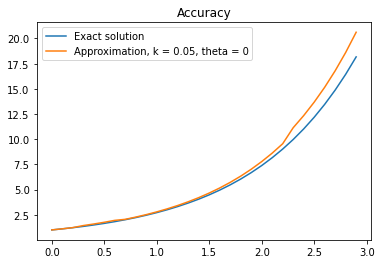

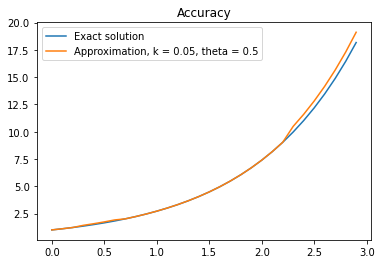

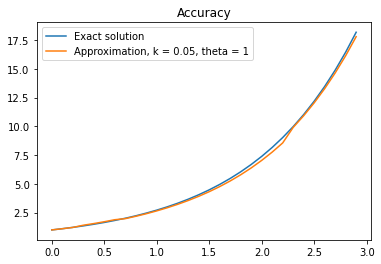

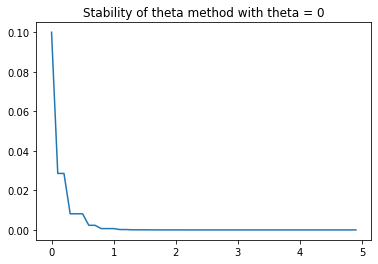

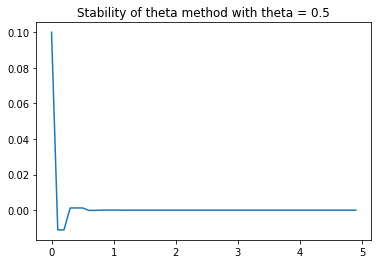

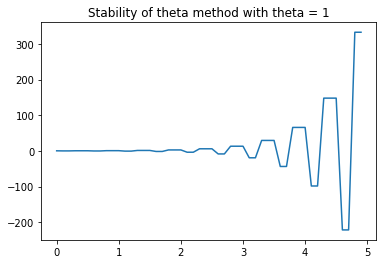

In [122]:
test_accuracy_theta()
test_stability_theta()

# **Results for system IVP**
The results for the system IVP are plotted below: 

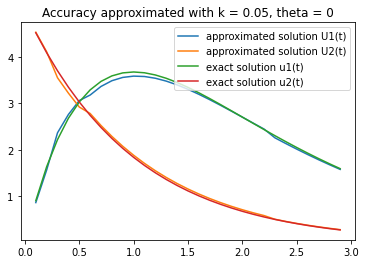

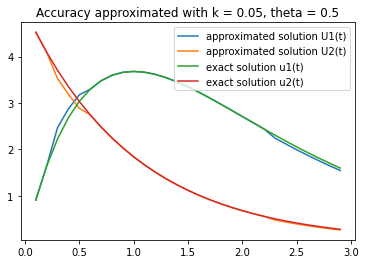

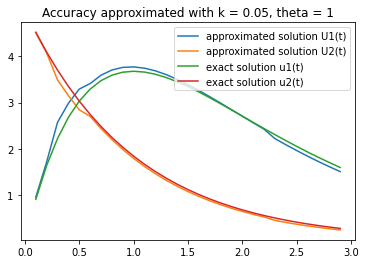

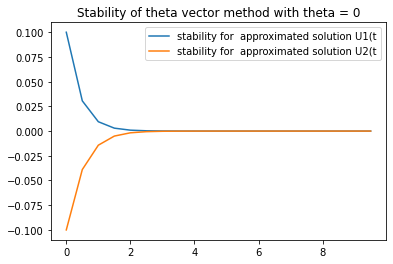

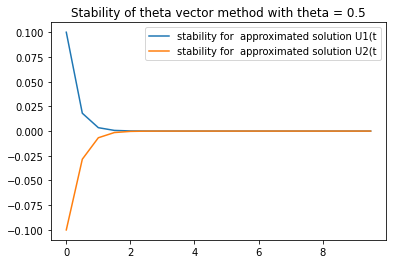

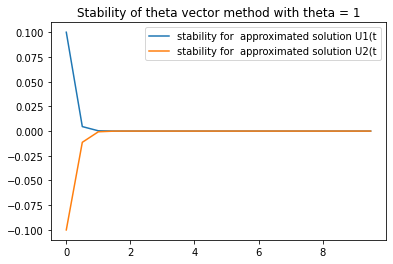

In [123]:
test_acc_theta_vec()
test_stability_theta_vec()

# **Discussion**

It can be seen that all approximations are reasonably good, with the trapezoidal method outperforming both the implicit and the explicit Euler method. I was surprised that there was such a visible difference between the method, as in previous labs the difference between different method have been harder to distinguish. I found the methods in the lab quite easy to implement, while the tests were harder. For the testing of the stability of the system of IVPs, I had to look to older students work for the matrices to be used. The lab was also discussed with Filippa Olofsson. 